# The full python workflow for semasiological token-level clouds 

In this notebook we will used the `nephosem` module in the `qlvl/nephosem` repository.

## 0. Initial setup 

This initial setup should probably be run in some sort of setup file or at the beginning of any script, in any case.
I'll try to run it with the newer deprel model.

In [1]:
import pandas as pd # to see concordance
import numpy as np # for "booleanize()"
from scipy import sparse # for "booleanize()"
import sys

Then, the `nephosem` module itself has to be included.
Until we can deploy it and install it with `pip`, we need to attach the path to the repository where it is hosted.



In [2]:
nephosemdir = "/home/projects/semmetrix/mariana_wolken/nephosem"
sys.path.append(nephosemdir)

From there, we can import the different functions that we need from the `nephosem` module. They could be imported as necessary for the different tasks, especially in a tutorial like this one.

In [3]:
from nephosem.conf import ConfigLoader # to setup the configuration
from nephosem import Vocab, TypeTokenMatrix # to manage frequency lists and matrices
from nephosem import ItemFreqHandler, ColFreqHandler, TokenHandler # to generate frequency lists and matrices
from nephosem import compute_association, compute_distance # to compute PPMI and distances
# compute_cosine would return similarities (I think), compute_simrank, similarity ranks
from nephosem.specutils.mxcalc import compute_token_weights, compute_token_vectors # for token level. I have incorporated Stefano's modifications in my copy, with adjustments
# from qlvl.basics.mxcalc import compute_token_weights, compute_token_vectors # non depmodel version
from nephosem.models.typetoken import build_tc_weight_matrix # for weighting at token level

# For dependencies
from nephosem.core.graph import SentenceGraph, MacroGraph, PatternGraph
from nephosem.models.deprel import DepRelHandler, read_sentence

## 1. Configuration 

Depending on what you need, you will have to set up some useful paths settings.
I like to have at least the path to my project (`mydir`), an output path within (`mydir + "output"`) and a GitHub path for the datasets that I will use in the visualization. There is no real reason not to have everything together, except that I did not think of it at the moment.

For this notebook, we will use a dataset in the same directory of the package: `tests/data/StanfDepSents`, because it includes dependency information.

You could also set up a file with filenames, but we won't use that here.

In [4]:
# mydir = "/home/projects/semmetrix/mariana_wolken/Wolken/"
mydir = f"{nephosemdir}/qlvl/tests/data"
output_path = f"{mydir}/output/"
# fnames_file = "{}/sources/LeNC260TwNC260.fnames".format(mydir)
# coldir = "/home/projects/semmetrix/NephoSem/input-data/frequency-matrices/QLVLNewsCorpus/"

The variables with paths is just meant to make it easier to manipulate filenames. The most important concrete step is to adapt the configuration file.

In [5]:
conf = ConfigLoader()
default_settings = conf.settings
settings = default_settings

The `line-machine` and `line-format` settings relate to the shape of the corpus file, or concretely to the lines of the tokens, and their content.

The first is a regular expression with capturing groups:
the versions for *QLVLNewsCorpus* and *Brown* are commented; the one for Stanford Dependency Sentences captures six items separated by tabs.

The `global-columns` (previously `line-format`) refers to the capturing groups in the line machine and labels them. In the case of the Stanford toy corpus, that is the word form, part-of-speech, lemma, id (index of item in the sentence), head (id of its dependency head) and dependency relation.

The `type`, `colloc` and `token` settings indicate the format of the type, collocate and token ID's. Here the target and collocate types are set to the default (combination of 'lemma' and 'pos'), and the token ID uses the values of the 'lemma' and 'pos' fields along with the file name/ID ('fid') and the line number starting from 1 ('lid'), all separated by slashes. The 'fid' is computed as the basename of the filename, without extension.

Afterwards we have settings for dependency-based models: the format of the node and edges in the graph, and the labels of the index and head information.

The `separator-line-machine` is optional for bag-of-words models (it indicates that we want to stop the window when we encounter it) but necessary for dependency-models:  it tells the software where sentences end.

In [6]:
# settings['line-machine'] = '[^\t]+\t([^\t]+)\t([^\t]+)\t([^\t]+)\t[^\t]+\t[^\t]+\t_\t_' #QLVLNewsCorpus, no dep
# settings['line-machine'] = '([^\t]+)\t([^\t])[^\t]*\t([^\t]+)' #Brown corpus
settings['line-machine'] = '([^\t]+)\t([^\t])[^\t]*\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)' #Stanford corpus
# settings['line-format'] = 'word,lemma,pos'
#settings['line-format'] = 'word,pos,lemma'
settings['global-columns'] = "word,pos,lemma,id,head,deprel" 

settings['type'] = 'lemma/pos'
settings['colloc'] = 'lemma/pos'
settings['token'] = 'lemma/pos/fid/lid'

# For dependencies
settings['node-attr'] = 'lemma,pos'
settings['edge-attr'] = 'deprel'
settings['currID'] = 'id'
settings['headID'] = 'head'

settings['separator-line-machine'] = '</s>'

print(settings['line-machine'])
print(settings['global-columns'])
print(settings['type'], settings['colloc'], settings['token'])

([^	]+)	([^	])[^	]*	([^	]+)	([^	]+)	([^	]+)	([^	]+)
word,pos,lemma,id,head,deprel
lemma/pos lemma/pos lemma/pos/fid/lid


Finally, you can set up the file encoding and the paths for corpus and output (although the output is specified separately as well, I think, and the 'corpus-path' is only useful if you do not specify filenames). The *QLVLNewsCorpus*  has a 'latin1' encoding, but we want 'utf-8' for the output.

In [7]:
# settings['file-encoding'] = 'latin1'
settings['file-encoding'] = 'utf-8'
settings['outfile-encoding'] = 'utf-8'
print(settings['file-encoding'])
print(settings['outfile-encoding'])
# output_path = settings['output-path']
settings['output-path'] = output_path
print("output path: ", output_path)
corpus_name = 'StanfDepSents'
settings['corpus-path'] = f"{mydir}/{corpus_name}/"
# settings['corpus-path'] = '/home/aardvark/corp/nl/'
print("corpus path: ", settings['corpus-path'])

utf-8
utf-8
output path:  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output/
corpus path:  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/StanfDepSents/


## 2. Frequency lists

The Vocab class is a dictionary (but with a `.dataframe` attribute that also returns a Pandas DataFrame with `item` and `freq` column). The steps to create one are twofold:

- Set up an ItemFreqHandler class with the settings
- Build the frequency list with its `.build_item_freq()` method. The `fnames` argument can be a list of paths or a path to a file with a list of paths. If it is not provided, the full content of `corpus-path` will be used.

In [8]:
ifhan = ItemFreqHandler(settings = settings)
vocab = ifhan.build_item_freq() # by default it uses multiprocessor, which is overkill with the toy Brown corpus

Building item frequency list...


In [9]:
vocab # it looks like a list of tuples but it is not: you cannot manipulate it as such

[('the/D', 53),('boy/N', 25),('eat/V', 22) ... ('ten/C', 1),('ask/V', 1),('about/I', 1)]

In [10]:
vocab.dataframe #the dataframe attribute returns a Pandas Dataframe and can be manipulated as such

,item,freq
0,the/D,53
1,boy/N,25
2,eat/V,22
3,apple/N,21
4,girl/N,21
5,be/V,11
6,healthy/J,10
7,look/V,8
8,a/D,6
9,at/I,6


In [11]:
vocab['the/D'] # The names of the items are the keys in the dictionary

53

In [12]:
vocab.keys()

['the/D',
 'boy/N',
 'should/M',
 'eat/V',
 'an/D',
 'apple/N',
 'have/V',
 'be/V',
 'and/C',
 'girl/N',
 'a/D',
 'healthy/J',
 'tasty/J',
 'all/P',
 'old/J',
 'give/V',
 'look/V',
 'at/I',
 'in/I',
 'house/N',
 'for/I',
 'say/V',
 'that/I',
 'that/W',
 'baby/N',
 'her/P',
 'by/I',
 'very/R',
 'food/N',
 ',/,',
 'during/I',
 'year/N',
 'like/V',
 'to/T',
 'without/I',
 'sit/V',
 'down/R',
 'about/R',
 'ten/J',
 'she/P',
 'love/V',
 'which/W',
 'him/P',
 'this/D',
 'not/R',
 'do/V',
 'as/I',
 'less/R',
 'what/W',
 'on/I',
 "'s/P",
 'both/D',
 'ten/C',
 'ask/V',
 'about/I']

In [13]:
Vocab(vocab.dataframe) # The dataframe can be retransformed into a Vocab object with Vocab

[('the/D', 53),('boy/N', 25),('eat/V', 22) ... ('very/R', 1),('which/W', 1),('without/I', 1)]

In [14]:
vocab_fname = f"{output_path}/{corpus_name}.nfreq"
vocab.save(vocab_fname) # save method
Vocab.load(vocab_fname) # load method

Saving frequency list (vocabulary)... (in 'utf-8')
Stored in /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output//StanfDepSents.nfreq


[('the/D', 53),('boy/N', 25),('eat/V', 22) ... ('ten/C', 1),('ask/V', 1),('about/I', 1)]

This is probably done only once per corpus. Once the main vocabulary list is compiled and stored, it can be further filtered.

It can be used to simply extract the frequency of a lemma, and for the `row_vocab` and `col_vocab` arguments of the `build_col_freq` method below.

## 3. Co-occurrence matrix

### 3.1. Creating type-level matrices 

Among the important settings to be fed to the object is the window span for the co-occurrence frequency.

In [15]:
settings['left-span'] = 4
settings['right-span'] = 4

#### Bag-of-words

Like creating the vocabulary list, creating a co-occurrence frequency matrix has two steps: set up the `ColFreqHandler` object and running its `.build_col_freq()` method.

In [16]:
cfhan = ColFreqHandler(settings=settings, row_vocab = vocab, col_vocab = vocab)

The `.build_col_freq()` method also has an optional `fname` argument requiring a list of paths or a path to a list of paths.
In addition, `row_vocab` and `col_vocab` ask for `Vocab` objects like `vocab` above.

In principle, you would create one overarching collocational matrix for all weight computations, with the full vocabulary for both rows and columns. But if the corpus is big, it may result in a huge files that can take a few minutes to load (and hours to create), so if you are only interested in the co-occurrence frequency between certain groups of items, you can use filtered vocabularies.

The result is a `TypeTokenMatrix` object.

In [17]:
freqMTX = cfhan.build_col_freq()
freqMTX.submatrix(row = ["the/D"], col=['of/C', 'be/V', 'a/D'])

Building collocate frequency matrix...


[1, 3]  of/C  be/V  a/D
the/D   1     11    5

In [18]:
sub_cfhan = ColFreqHandler(settings=settings, row_vocab=vocab[['the/D']], col_vocab=vocab[['of/C', 'be/V', 'a/D']])
subfreqMTX = sub_cfhan.build_col_freq()
subfreqMTX

Building collocate frequency matrix...


[1, 2]  a/D  be/V
the/D   5    11

In [19]:
fname = f"{output_path}/{corpus_name}.wcmx.pac" # ideally you will code parameter settings into the name
freqMTX.save(fname) # save method
TypeTokenMatrix.load(fname)


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output//StanfDepSents.wcmx.pac


[55, 55]  's/P  ,/,  a/D  about/I  about/R  all/P  an/D  ...
's/P      NaN   NaN  NaN  NaN      NaN      NaN    NaN   ...
,/,       NaN   2    2    NaN      NaN      NaN    NaN   ...
a/D       NaN   2    NaN  NaN      NaN      NaN    NaN   ...
about/I   NaN   NaN  NaN  NaN      NaN      NaN    NaN   ...
about/R   NaN   NaN  NaN  NaN      NaN      NaN    NaN   ...
all/P     NaN   NaN  NaN  NaN      NaN      NaN    NaN   ...
an/D      NaN   NaN  NaN  NaN      NaN      NaN    NaN   ...
...       ...   ...  ...  ...      ...      ...    ...   ...

Important attributes of `TypeTokenMatrix` are `row_items` and `col_items`: the names of the rows and columns.

One of the important methods of the `TypeTokenMatrix` class is `.submatrix()`, which takes lists of items, as would be returned by `row_items` and `col_items`, to **subset the matrix**. *However*, it does not respond well when the requested list includes items that are missing from the row/column names of the matrix. It is best to first obtain the intersection between the items in the row/column names and the desired list before using it for subsetting.

In [20]:
freqMTX.submatrix(row = ["the/D"], col=['of/C', 'be/V', 'a/D'])

[1, 3]  of/C  be/V  a/D
the/D   1     11    5

In [21]:
"bird/N" in freqMTX.col_items

False

In [22]:
freqMTX.submatrix(row = ["the/D"], col=['of/C', 'be/V', 'bird/N'])
# Instead of an error or warning or just dropping the extra element, it copies the value of another column and creates it

[1, 3]  of/C  be/V  bird/N
the/D   1     11    1

In [23]:
freqMTX.submatrix(row = ["the/D"], col=[c for c in ['of/C', 'be/V', 'bird/N'] if c in freqMTX.col_items])
# Best to first check the intersection

[1, 1]  be/V
the/D   11

#### Dependency-based

Dependency-based models require yet another piece of information: templates. On the one hand, we have .graphml files that indicate relationships between elements. On the other, we have .xml files which specify the role of the node and features in the relationships. For example, in .graphml you would say that you want the relationship between a verb and its direct object; in the .xml, you would clarify that the verb is your feature and the object is your target. You would also specify whether you want the lemma of the verb as the feature or, instead, the full path (just *eat/V* or `eat/v->dobj:#T`, with `#T` filling in the role of the target.

For the type-level, we will exemplify with patterns that do not specify the *kind* of relationships but the number of steps, only selecting paths with one step between the target and the context word (*aka* LEMMAPATH1).

First, we have to upload the files.

In [24]:
path_graphml_fname = f"{mydir}/templates/LEMMAPATH-Stanford.template.graphml"
path_patterns = PatternGraph.read_graphml(path_graphml_fname)

path_macro_fname = f"{mydir}/templates/LEMMAPATH1-Stanford.target-feature-macro.xml"
path_macros = MacroGraph.read_xml(path_macro_fname, path_patterns)

This is a fragment of the raw `path_patterns`, the .graphml file:

```xml
<graphml xmlns="http://graphml.graphdrawing.org/xmlns"
      xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
      xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns
        http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">
    <key id="n1" for="node" attr.name="lemma" attr.type="string">
        <default>(.+)</default>
    </key>
    <key id="n2" for="node" attr.name="pos" attr.type="string">
        <default>(\w+)</default>
    </key>
    <key id="e1" for="edge" attr.name="deprel" attr.type="string"/>
    <graph id="1" edgedefault="directed">
        <node id="1"></node>
        <node id="2"></node>
        <edge source="1" target="2">
            <data key="e1">\w+</data>
        </edge>
    </graph>
</graphml>
```

The structure is as follows: the main element is a `<graphml>` tag, that always stay the same, within which we have three `<key>` tags setting up the main elements we are now interested in: lemma and pos for the nodes, and deprel for the key. Inside them, the `<default>` tag lets us set up a default regex expression for filtering these items, but then we can make further specifications within the specific graphs. Afterwards, we can add as many `<graph>` tags as we want, each of them representing one pattern to match.

Each `<graph>` tag has an id (which is a string with a number) and a property `edgedefault="directed"` (not sure how compulsory that is). Inside the `<graph>` tag we can have `<node>` and `<edge>` tags indicating the nodes (items) and edges (relationships) in the pattern. Here we have two nodes, 1 and 2, joined by an edge that goes from 1 (source attribute) to 2 (target attribute): node 1 is the head of node 2, e.g the verb for its direct object. We could specify that we want the direct object by filling in the `<data>` element within `<edge>` as "dobj" instead of "\w+". Note that this `<data>` element has a `key` attribute with value "e1", meaning that it's talking about a "deprel" element. Within the nodes, we could have a similar `<data>` element with a `key` attribute and valeue "n1" if we want to filter by lemma or "n2" if we want to filter by part-of-speech.

Next, we have a fragment of the raw `path_macros`, the .xml file:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<target-feature-list>
    <target-fmt>
        <node-fmt>
            <lemma group="1"/>
            <pos group="1"/>
            <fid group="1"/>
            <lid group="1"/>
            <string connector="/">lemma/pos/fid/lid</string>
        </node-fmt>
    </target-fmt>
    <feature-fmt>
        <node-fmt>
            <lemma group="1"/>
            <pos group="1"/>
            <string connector="/">lemma/pos</string>
        </node-fmt>
        <edge-fmt>deprel</edge-fmt>
    </feature-fmt>
    <target-feature-macro id="1">
        <sub-graph-pattern id="1"/>
        <target nodeID="1">
            <description>Empty</description>
        </target>
        <feature featureID="2">
            <description>Words that depend directly on the target.</description>
        </feature>
    </target-feature-macro>
</target-feature-list>
```

In this case, after the small xml preamble, we have the mail element `<target-feature-list>`, within which we find one `<target-fmt>` element to specify the format of the target, one `<feature-fmt>` tag to specify the format of the feature elements (the columns of our matrices), and as many `<target-feature-macro>` elements as we have templates/macros to describe.

In the `<target-fmt>` element, the `<node-fmt>` element gives instructions to capture the elements of a node and chain them. The `fid` and `lid` elements are only relevant at token-level. The same goes for `<feature-fmt>`, where a reference to the edge is included.

The `<target-feature-macro>` element has an attribute "id" (with a number as a string) and three child elements. The first, `<sub-graph-pattern>`, also has an attribute "id" that points to the id of a `<graph>` element in the .graphml file. Totally different from the "id" of the parent element. The `<target>` and `<feature>` elements point to the nodes in that `<graph>` that take the roles of node and feature. Here, because the "nodeID" attribute of `<target>` is "1", the target is the head of the relationship in that graph; because the "featureID" attribute of `<feature>` is "2", the feature is the dependent. Optionally, you can add a description of the item. With this format, the features will be the lemma/pos combination; if you exclude the "featureID" attribute altogether, the full template will become the feature (including dependency information).

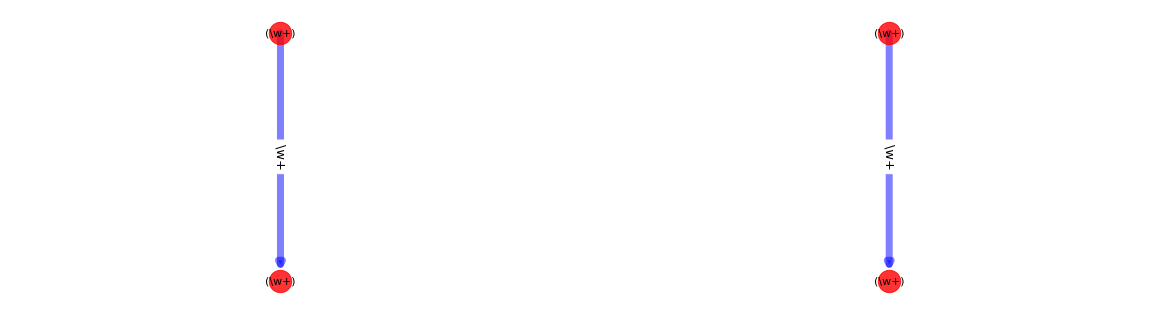

In [25]:
from nephosem.specutils.deputils import parse_pattern, draw_tree, draw_match, draw_labels, get_root
import matplotlib.pyplot as plt
%matplotlib inline
def plot_patterns(macros_list):
    plt.rcParams['figure.figsize'] = (20.0, 32.0)
    for i in range(len(macros_list)):
        plt.subplot(5, 2, i+1)
        draw_labels(macros_list[i].graph, v_labels='pos', e_labels='deprel')
    plt.show()

# This shows the patterns included with these files --- it is always the same pattern,
# but in the macros file we include relationships in both directions, so we have two macros.
plot_patterns(path_macros)

In [26]:
# The only difference between type- and token-level here is the "mode" argument
path_dephan_type = DepRelHandler(settings, workers=4, targets = vocab, mode='type')
path_dephan_type.read_templates(macros=path_macros)
pathMTX = path_dephan_type.build_dependency()
pathMTX.submatrix(row = ["girl/N"]).drop(axis = 1, n_nonzero = 0)

Building dependency features...



Building matrix...


[1, 12]  's/P  apple/N  ask/V  at/I  boy/N  by/I  eat/V  ...
girl/N   1     1        1      1     2      1     6      ...

In [27]:
pathfull_macro_fname = f"{mydir}/templates/LEMMAPATH1-Stanford-full.target-feature-macro.xml"
pathfull_macros = MacroGraph.read_xml(pathfull_macro_fname, path_patterns)
pathfull_dephan_type = DepRelHandler(settings, workers=4, targets = vocab, mode='type')
pathfull_dephan_type.read_templates(macros=pathfull_macros)
pathfullMTX = pathfull_dephan_type.build_dependency()
pathfullMTX.submatrix(row = ["girl/N"]).drop(axis = 1, n_nonzero = 0)
# Note that the dependency itself is replaced by "*" because the regex in the patterns file does not capture it
# (it doesn't have parentheses)

Building dependency features...



Building matrix...


[1, 12]  #T#->*:'s/P  #T#->*:old/J  #T#->*:the/D  apple/N->*:#T#  ask/V->*:#T#  at/I->*:#T#  boy/N->*:#T#  ...
girl/N   1            1             21            1               1             1            2             ...

In practice, we will be more interested in the transposed counterpart of this matrix: when we obtain token-level matrices of this kind, the patterns will be the columns and will need to be multiplied by a SOCC matrix where the patterns are the rows :).

In [28]:
pathfullMTX.transpose().submatrix(col = ["girl/N", "boy/N"]).drop(axis = 0, n_nonzero = 0)

[24, 2]        girl/N  boy/N
#T#->*:'s/P    1       NaN
#T#->*:a/D     NaN     2
#T#->*:all/P   NaN     1
#T#->*:and/C   NaN     2
#T#->*:baby/N  NaN     1
#T#->*:both/D  NaN     1
#T#->*:girl/N  NaN     2
...            ...     ...

### 3.2 Manipulating co-occurrence matrices

One of the things you will want to do is **compute association measures**, which will be the values of the vectors, either for type or token level matrices. This is done with the `compute_association()`, a function that takes a (sub)matrix, row and column vocabulary objects and the kind of measure.

Something else you might be interested in is computing a distance matrix, but we will look into that with the token-level matrix (even though it is, of course, possible at type-level as well).

In [29]:
nfreq = Vocab(freqMTX.sum(axis=1))
cfreq = Vocab(freqMTX.sum(axis=0))
pmi = compute_association(freqMTX, nfreq=nfreq, cfreq=cfreq, meas = 'pmi')
pmi



************************************
function    = compute_association
  time      = 0.01668 sec
************************************



[55, 55]  's/P  ,/,        a/D        about/I  about/R  all/P  an/D  ...
's/P      NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
,/,       NaN   2.0384464  1.2940059  NaN      NaN      NaN    NaN   ...
a/D       NaN   1.2940059  NaN        NaN      NaN      NaN    NaN   ...
about/I   NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
about/R   NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
all/P     NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
an/D      NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
...       ...   ...        ...        ...      ...      ...    ...   ...

Even if you only want the values for a few of the items, you will need to use the full row and column sums for `nfreq` and `cfreq`.

You can also use the `.drop()` method (of `TypeTokenMatrix`) to **remove** all the rows (`axis = 0`) or columns (`axis = 1`) with no positive values.

In [30]:
subMTX = freqMTX.submatrix(row = ["the/D"]).drop(axis = 1, n_nonzero = 0)
subpmi = compute_association(subMTX, nfreq=nfreq, cfreq=cfreq, meas = 'pmi')
subpmi



************************************
function    = compute_association
  time      = 0.01447 sec
************************************



[1, 53]  's/P         ,/,        a/D          about/I      about/R      all/P       an/D        ...
the/D    0.030027887  -0.611826  -0.43997574  -0.15229367  0.030027887  0.25317144  -1.0685844  ...

Read the documentation to find other possible measures.

In [31]:
subllr = compute_association(subMTX, nfreq=nfreq, cfreq=cfreq, meas = 'llik')
subllr



************************************
function    = compute_association
  time      = 0.01483 sec
************************************



[1, 53]  's/P          ,/,        a/D        about/I      about/R       all/P      an/D       ...
the/D    0.0011144616  1.1206855  1.3934952  0.030076249  0.0011144616  0.0751342  1.9897448  ...

## 4. Token level

All matrices below belong to the `TypeTokenMatrix` class, so even if I don't, they can be saved with the `.save()` method and loaded with `TypeTokenMatrix.load()`.

### 4.1 Collecting tokens

In [32]:
query = vocab.subvocab(["girl/N"]) # which is equivalent to vocab[["girl/N"]]

#### Bag-of-words

As always, collecting tokens go into two steps: setting up the `TokenHandler` class and then running the `retrieve_tokens()` method (there are other alternative methods too, I understand). The `query` argument of the class is a Vocab object with the types from which we want the tokens.
Among the important settings you might want to reconfigure are the **window span** (like above) and the `single-boundary-machine`, a regular expression to match lines that correspond to sentence (or whatever) boundaries, such as `^</sentence>$` in the case of *QLVLNewsCorpus* or `</s>` for this case.

Next to `fnames`, the method (as well as the class itself) includes a `col_vocab` argument which takes a `Vocab` object to select which context words can be captured (rather than, by default, all context words).

I find `fnames` particularly useful to avoid browsing all of a huge corpus if I already know that I want to extract a sample and which files that sample resides in.

(Some notes comparing to the old code:

Before, the code required us to specify col_vocab, or it crashed. Now it doesn't.

The new code also ignores all the context words that do not occur in the window of the tokens (unlike the previous code, which could include many empty columns).

In [33]:
tokhan = TokenHandler(query, settings=settings)
tokens = tokhan.retrieve_tokens()
tokens

Scanning tokens of queries in corpus...


[21, 39]                   that/W  which/W  about/R  be/V  ,/,  this/D  apple/N  ...
girl/N/StanfDepSents.4/7   NaN     NaN      NaN      NaN   NaN  NaN     4        ...
girl/N/StanfDepSents.4/15  4       NaN      NaN      NaN   NaN  NaN     3        ...
girl/N/StanfDepSents.3/21  NaN     NaN      NaN      NaN   NaN  NaN     NaN      ...
girl/N/StanfDepSents.7/7   NaN     NaN      NaN      NaN   NaN  NaN     3        ...
girl/N/StanfDepSents.7/25  NaN     NaN      NaN      NaN   NaN  NaN     3        ...
girl/N/StanfDepSents.2/29  NaN     NaN      NaN      -4    NaN  NaN     NaN      ...
girl/N/StanfDepSents.9/14  NaN     NaN      NaN      NaN   NaN  NaN     NaN      ...
...                        ...     ...      ...      ...   ...  ...     ...      ...

For the ones interested in running `retrieve_token_nodes()` instead, that method doesn't exist anymore as a separate function, but its output can be found in the `type2toks` attribute of the `TokenHandler`.

The `type2toks` attribute is then a dictionary with types as keys and and a `TypeNode` object as value, which has `tokens` attribute that is a list of `TokenNode` objects. From them, we can create a concordance with a function like `tokenConcordance()` below :)

In [34]:
tokhan.type2toks

{'girl/N': girl/N}

In [35]:
type(tokhan.type2toks["girl/N"])

qlvl.core.terms.TypeNode

In [57]:
firstToken = tokhan.type2toks["girl/N"].tokens[0]
type(firstToken)

qlvl.core.terms.TokenNode

In [80]:
def tokenConcordance(token):
    leftContext = " ".join([x.word for x in token.lcollocs])
    rightContext = " ".join([x.word for x in token.rcollocs])
    return f"{leftContext} {token.word} {rightContext}"

In [70]:
tokenConcordance(firstToken)

'boy says that the girl should eat the apple'

In [81]:
#If you have several queries, you just need to replace tokhan.type2toks["girl/N"].tokens with a flattened version
# [tok for typ in tokhan.type2toks.values() for tok in ctyp.tokens]
pd.DataFrame([{"token_id" : str(token), "text" : tokenConcordance(token)} for token in tokhan.type2toks["girl/N"].tokens])

,text,token_id
0,boy says that the girl should eat the apple,girl/N/StanfDepSents.4/7
1,The girl eats the apple that,girl/N/StanfDepSents.4/15
2,The boy and the girl eat a healthy and,girl/N/StanfDepSents.3/21
3,old boy gives the girl a baby apple,girl/N/StanfDepSents.7/7
4,The boy asked the girl about eating apples,girl/N/StanfDepSents.7/25
5,are eaten by the girl,girl/N/StanfDepSents.2/29
6,The older girl looks at a boy,girl/N/StanfDepSents.9/14
7,The boy gives the girl a tasty healthy apple,girl/N/StanfDepSents.6/6
8,The girl does n't eat,girl/N/StanfDepSents.6/21
9,The girl sits down,girl/N/StanfDepSents.10/13


In [37]:
nouns = vocab.subvocab([x for x in vocab.keys() if x.endswith("N")])
query2 = vocab.subvocab(["girl/N", "boy/N"])

In [38]:
tokhan2 = TokenHandler(query2, settings=settings, col_vocab = nouns) # multiple types as targets
tokens2 = tokhan2.retrieve_tokens() # Subset of context words
tokens2

Scanning tokens of queries in corpus...


[46, 7]                    year/N  apple/N  girl/N  food/N  house/N  boy/N  baby/N
girl/N/StanfDepSents.6/6   NaN     1        NaN     NaN     NaN      -1     NaN
girl/N/StanfDepSents.6/21  NaN     NaN      NaN     NaN     NaN      NaN    NaN
girl/N/StanfDepSents.5/19  NaN     NaN      NaN     NaN     NaN      NaN    NaN
girl/N/StanfDepSents.2/29  NaN     NaN      NaN     NaN     NaN      NaN    NaN
girl/N/StanfDepSents.3/21  NaN     NaN      NaN     NaN     NaN      -1     NaN
girl/N/StanfDepSents.9/14  NaN     NaN      NaN     NaN     NaN      1      NaN
girl/N/StanfDepSents.4/7   NaN     1        NaN     NaN     NaN      -1     NaN
...                        ...     ...      ...     ...     ...      ...    ...

In [100]:
# In this case, the concordance looks weird because we have only used nouns as collocates
# In order to capture the full concordance, we should run TokenHandler with the full vocabulary and THEN filter the columns
allTokens = [tok for typ in tokhan2.type2toks.values() for tok in typ.tokens]
pd.DataFrame([{"token_id" : str(token), "text" : tokenConcordance(token)} for token in allTokens])

,text,token_id
0,boy girl apple,girl/N/StanfDepSents.6/6
1,girl,girl/N/StanfDepSents.6/21
2,girl,girl/N/StanfDepSents.5/19
3,girl,girl/N/StanfDepSents.2/29
4,boy girl,girl/N/StanfDepSents.3/21
5,girl boy,girl/N/StanfDepSents.9/14
6,boy girl apple,girl/N/StanfDepSents.4/7
7,girl apple,girl/N/StanfDepSents.4/15
8,girl boy,girl/N/StanfDepSents.11/3
9,apple girl,girl/N/StanfDepSents.11/19


Dependency models can use different types of patterns. Here we will see three:

- Lemmarel, where the dependency is selected by a specific set of relationships and the context feature is a lemma.
- Lemmapath, where the dependency is selected based on the number of steps on the dependency path (like above) and the context feature is a lemma.
- Deppath, where the dependency is selected based on the number of steps on the dependency path but the full dependency relation is the context feature. (Deprel is of course also possible but I will not show it.)

#### Lemmarel

In the first dependency-based model, we will look at templates where a noun is the target and the features could be the verb of which it is subject or direct object, its modifier or an item from which it depends via a preposition.

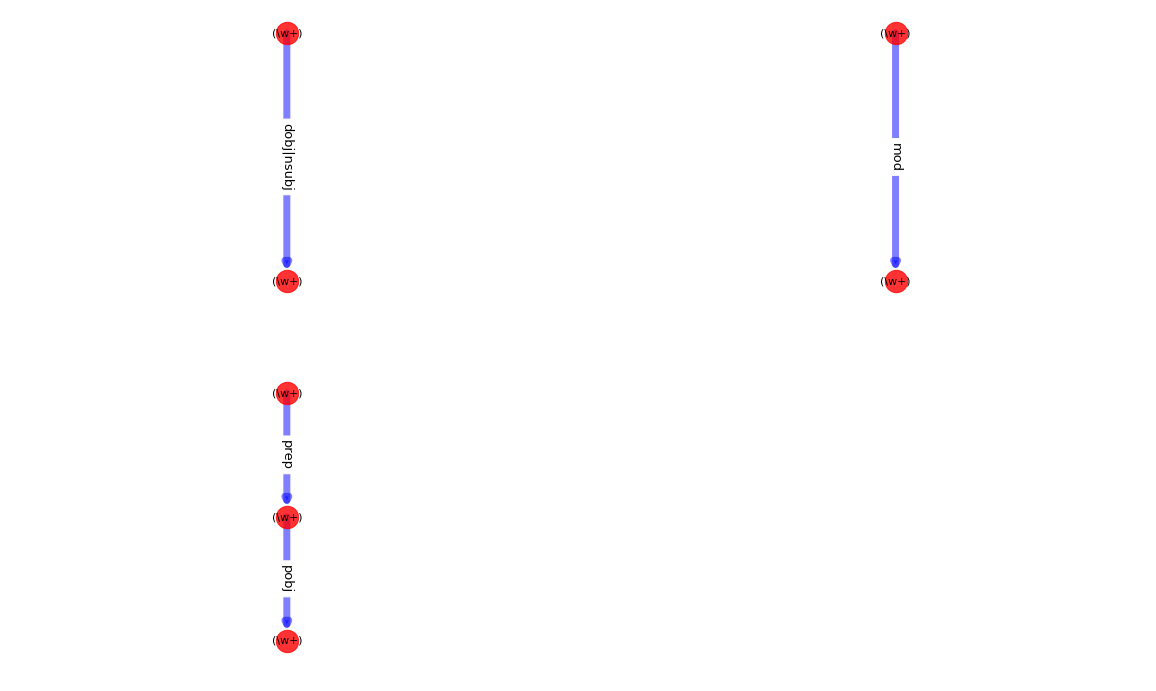

In [39]:
rel_graphml_fname = f"{mydir}/templates/LEMMAREL-Stanford.nouns.template.graphml"
rel_patterns = PatternGraph.read_graphml(rel_graphml_fname)

rel_macro_fname = f"{mydir}/templates/LEMMAREL1-Stanford.nouns.target-feature-macro.xml"
rel_macros = MacroGraph.read_xml(rel_macro_fname, rel_patterns)
plot_patterns(rel_macros)

Like in all other dependency-based models, we first create an object of the `DepRelHandler` class (with either mode 'type' or, in this case, 'token') and then we give the macros to the `.read_templates()` method.

In [40]:
rel_dephan = DepRelHandler(settings, workers=4, targets=query, mode='token')
rel_dephan.read_templates(macros=rel_macros)
rel_tokens = rel_dephan.build_dependency()
rel_tokens

Building dependency features...



Building matrix...


[15, 6]                     ask/V  at/I  eat/V  give/V  look/V  sit/V
girl/N/StanfDepSents.1/13   NaN    1     NaN    NaN     NaN     NaN
girl/N/StanfDepSents.1/20   NaN    NaN   1      NaN     NaN     NaN
girl/N/StanfDepSents.1/3    NaN    NaN   NaN    NaN     1       NaN
girl/N/StanfDepSents.10/13  NaN    NaN   NaN    NaN     NaN     1
girl/N/StanfDepSents.10/19  NaN    NaN   1      NaN     NaN     NaN
girl/N/StanfDepSents.11/19  NaN    NaN   NaN    1       NaN     NaN
girl/N/StanfDepSents.11/28  NaN    NaN   NaN    NaN     1       NaN
...                         ...    ...   ...    ...     ...     ...

#### Lemmapath

This is the token-level counterpart of the type-level model shown above: the rows are individual instances instead of type-level vectors.

In [41]:
path_dephan = DepRelHandler(settings, workers=4, targets=query, mode='token')
path_dephan.read_templates(macros=path_macros)
path_tokens = path_dephan.build_dependency()
path_tokens

Building dependency features...



Building matrix...


[21, 12]                    's/P  apple/N  ask/V  at/I  boy/N  by/I  eat/V  ...
girl/N/StanfDepSents.1/13   NaN   NaN      NaN    1     NaN    NaN   NaN    ...
girl/N/StanfDepSents.1/20   NaN   NaN      NaN    NaN   NaN    NaN   1      ...
girl/N/StanfDepSents.1/3    NaN   NaN      NaN    NaN   NaN    NaN   NaN    ...
girl/N/StanfDepSents.10/13  NaN   NaN      NaN    NaN   NaN    NaN   NaN    ...
girl/N/StanfDepSents.10/19  NaN   NaN      NaN    NaN   NaN    NaN   1      ...
girl/N/StanfDepSents.11/19  NaN   NaN      NaN    NaN   NaN    NaN   NaN    ...
girl/N/StanfDepSents.11/28  NaN   NaN      NaN    NaN   NaN    NaN   NaN    ...
...                         ...   ...      ...    ...   ...    ...   ...    ...

#### Deppath

This is the token-level counterpart of the second type-level model shown above; that (transposed) type-level model would serve as the second-order matrix for this token-level matrix.

In [42]:
pathfull_dephan = DepRelHandler(settings, workers=4, targets=query, mode='token')
pathfull_dephan.read_templates(macros=pathfull_macros)
pathfull_tokens = pathfull_dephan.build_dependency()
pathfull_tokens

Building dependency features...



Building matrix...


[21, 12]                    #T#->*:'s/P  #T#->*:old/J  #T#->*:the/D  apple/N->*:#T#  ask/V->*:#T#  at/I->*:#T#  boy/N->*:#T#  ...
girl/N/StanfDepSents.1/13   NaN          NaN           1             NaN             NaN           1            NaN           ...
girl/N/StanfDepSents.1/20   NaN          NaN           1             NaN             NaN           NaN          NaN           ...
girl/N/StanfDepSents.1/3    NaN          NaN           1             NaN             NaN           NaN          NaN           ...
girl/N/StanfDepSents.10/13  NaN          NaN           1             NaN             NaN           NaN          NaN           ...
girl/N/StanfDepSents.10/19  NaN          NaN           1             NaN             NaN           NaN          NaN           ...
girl/N/StanfDepSents.11/19  NaN          NaN           1             NaN             NaN           NaN          NaN           ...
girl/N/StanfDepSents.11/28  NaN          NaN           1             NaN             NaN  

### 4.2 Weight or booleanize

The result is also a `TypeTokenMatrix` object, with `.submatrix()` and `.drop()` methods, but with tokens instead of types on its rows and with *positions* as its values. It can be directly fed into a `compute_token_weights()` function in order to replace the positions with weights, but if we do not want to implement any weighting we should do something else: transform it into a boolean matrix.

Here, `tokens` could be replaced by `rel_tokens`, `path_tokens` or `pathfull_tokens`.

In [43]:
def booleanize(ttmx, include_negative = True):
    # For PPMI matrices, include_negative should be False
    boolean_array = ttmx.matrix.toarray() != 0 if include_negative else ttmx.matrix.toarray() > 0
    boolean_sparse = sparse.csr_matrix(boolean_array.astype(np.int))
    return TypeTokenMatrix(boolean_sparse, ttmx.row_items, ttmx.col_items).drop(axis = 1, n_nonzero = 0)
tokens = booleanize(tokens)
tokens

[21, 39]                   that/W  which/W  about/R  be/V  ,/,  this/D  apple/N  ...
girl/N/StanfDepSents.4/7   NaN     NaN      NaN      NaN   NaN  NaN     1        ...
girl/N/StanfDepSents.4/15  1       NaN      NaN      NaN   NaN  NaN     1        ...
girl/N/StanfDepSents.3/21  NaN     NaN      NaN      NaN   NaN  NaN     NaN      ...
girl/N/StanfDepSents.7/7   NaN     NaN      NaN      NaN   NaN  NaN     1        ...
girl/N/StanfDepSents.7/25  NaN     NaN      NaN      NaN   NaN  NaN     1        ...
girl/N/StanfDepSents.2/29  NaN     NaN      NaN      1     NaN  NaN     NaN      ...
girl/N/StanfDepSents.9/14  NaN     NaN      NaN      NaN   NaN  NaN     NaN      ...
...                        ...     ...      ...      ...   ...  ...     ...      ...

Then, if we want to weight the values with the PPMI between the context words and the target, we can use `compute_token_weights()` and the PPMI matrix; if we only want to *select* the context words with a positive PMI, we can use the boolean version of the PPMI matrix.

This PPMI matrix has to have the same column items as the token-level matrix, and at least the types of the targets in its row names.

In [44]:
sub_pmi = pmi.submatrix(row = query.get_item_list(), col = tokens.col_items).drop(axis = 1, n_nonzero = 0) #Of course, it's best to check for the intersection...
sub_pmi

[1, 39]  that/W     which/W    about/R    be/V         ,/,         this/D     apple/N     ...
girl/N   0.3507146  0.3507146  0.8207182  -0.97104126  -0.5142828  1.0438617  0.18944645  ...

The bag-of-words pmi matrix works for all token-level matrices except the one with full dependencies as features. In order to weight that one, we would need to calculate PMI values between the lemmas and the paths.

In [45]:
pathfull_nfreq = Vocab(pathfullMTX.sum(axis=1))
pathfull_cfreq = Vocab(pathfullMTX.sum(axis=0))
pathfull_pmi = compute_association(pathfullMTX, nfreq=pathfull_nfreq, cfreq=pathfull_cfreq, meas = 'pmi')
pathfull_pmi.submatrix(row = query.get_item_list(), col = pathfull_tokens.col_items).drop(axis = 1, n_nonzero = 0)



************************************
function    = compute_association
  time      = 0.01623 sec
************************************



[1, 12]  #T#->*:'s/P  #T#->*:old/J  #T#->*:the/D  apple/N->*:#T#  ask/V->*:#T#  at/I->*:#T#  boy/N->*:#T#  ...
girl/N   2.325058     0.93876356    1.3992884     -0.81043625     1.2264457     0.5332985    -0.5081554    ...

In [46]:
weighted_tokens = compute_token_weights(tokens.submatrix(col = sub_pmi.col_items), sub_pmi)
weighted_tokens

[21, 39]                   that/W  which/W  about/R  be/V     ,/,  this/D  apple/N  ...
girl/N/StanfDepSents.4/7   NaN     NaN      NaN      NaN      NaN  NaN     0.1894   ...
girl/N/StanfDepSents.4/15  0.3507  NaN      NaN      NaN      NaN  NaN     0.1894   ...
girl/N/StanfDepSents.3/21  NaN     NaN      NaN      NaN      NaN  NaN     NaN      ...
girl/N/StanfDepSents.7/7   NaN     NaN      NaN      NaN      NaN  NaN     0.1894   ...
girl/N/StanfDepSents.7/25  NaN     NaN      NaN      NaN      NaN  NaN     0.1894   ...
girl/N/StanfDepSents.2/29  NaN     NaN      NaN      -0.9710  NaN  NaN     NaN      ...
girl/N/StanfDepSents.9/14  NaN     NaN      NaN      NaN      NaN  NaN     NaN      ...
...                        ...     ...      ...      ...      ...  ...     ...      ...

In [47]:
selected_tokens = compute_token_weights(tokens.submatrix(col = sub_pmi.col_items), booleanize(sub_pmi))
selected_tokens

[21, 39]                   that/W  which/W  about/R  be/V    ,/,  this/D  apple/N  ...
girl/N/StanfDepSents.4/7   NaN     NaN      NaN      NaN     NaN  NaN     1.0000   ...
girl/N/StanfDepSents.4/15  1.0000  NaN      NaN      NaN     NaN  NaN     1.0000   ...
girl/N/StanfDepSents.3/21  NaN     NaN      NaN      NaN     NaN  NaN     NaN      ...
girl/N/StanfDepSents.7/7   NaN     NaN      NaN      NaN     NaN  NaN     1.0000   ...
girl/N/StanfDepSents.7/25  NaN     NaN      NaN      NaN     NaN  NaN     1.0000   ...
girl/N/StanfDepSents.2/29  NaN     NaN      NaN      1.0000  NaN  NaN     NaN      ...
girl/N/StanfDepSents.9/14  NaN     NaN      NaN      NaN     NaN  NaN     NaN      ...
...                        ...     ...      ...      ...     ...  ...     ...      ...

### 4.3 Second-order dimensions

Now `tokens`, `weighted_tokens` and `selected_tokens` are alternatives that can be used to create the final vectors, for which we need one final type-level (PPMI) matrix to multiply them for and the `compute_token_vectors()` function.

The first two arguments of this function, `tcWeightMTX` and `soccMTX`, are the token level and second-order type level matrices involved. Next to them there is an argument `operation` to decide how to merge the type level vectors of the context words to form the token-level vector: by default, it's addition, but it could also be multiplication or a weighted mean. In addition, the argument `normalization`, with L1 as default, sets whether and how the vectors should be normalized.

The second-order matrix has to have, as rows, the columns of the token-level matrix, while the columns will be the final dimensions. I understand that if we wanted to use SVD, it would be applied to that second-order matrix before the multiplication.

In [48]:
ppmi = pmi.multiply(pmi > 0).drop(axis = 1, n_nonzero = 0) # The multiply() method with the boolean matrix lets us set all values below 0 to 0
intersection_cw = [x for x in tokens.col_items if x in ppmi.row_items]
ppmi

[55, 55]  's/P  ,/,        a/D        about/I  about/R  all/P  an/D  ...
's/P      NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
,/,       NaN   2.0384464  1.2940059  NaN      NaN      NaN    NaN   ...
a/D       NaN   1.2940059  NaN        NaN      NaN      NaN    NaN   ...
about/I   NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
about/R   NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
all/P     NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
an/D      NaN   NaN        NaN        NaN      NaN      NaN    NaN   ...
...       ...   ...        ...        ...      ...      ...    ...   ...

In [49]:
filtered_tokens = tokens.submatrix(col = intersection_cw).drop(axis = 0, n_nonzero = 0)
filtered_soc = ppmi.submatrix(row = intersection_cw).drop(axis = 1, n_nonzero = 0)
tokvecs = compute_token_vectors(filtered_tokens, filtered_soc) # This is currently the old version: I think Stefano should commit his fix himself
tokvecs

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...


[21, 55]                   's/P    ,/,     a/D     about/I  about/R  all/P   an/D    ...
girl/N/StanfDepSents.4/7   0.0130  NaN     0.0055  0.0253   0.0230   0.0146  0.0509  ...
girl/N/StanfDepSents.4/15  0.0220  NaN     0.0077  0.0311   0.0389   0.0050  0.0303  ...
girl/N/StanfDepSents.3/21  0.0004  0.0311  0.0229  0.0160   0.0112   0.0159  0.0155  ...
girl/N/StanfDepSents.7/7   0.0117  0.0136  0.0279  0.0157   0.0117   0.0432  0.0456  ...
girl/N/StanfDepSents.7/25  0.0154  NaN     0.0065  0.0808   0.0273   0.0174  0.0320  ...
girl/N/StanfDepSents.2/29  0.0006  0.0327  NaN     0.0138   0.0181   0.0412  0.0181  ...
girl/N/StanfDepSents.9/14  0.0461  0.0286  0.0191  0.0073   0.0004   0.0508  0.0286  ...
...                        ...     ...     ...     ...      ...      ...     ...     ...

In [50]:
tokvecs.save(f"{output_path}/{corpus_name}.ttmx.ppmi.pac")


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output//StanfDepSents.ttmx.ppmi.pac


### 4.4 Cosine distances

The final element, `tokvecs`, is the actual token-level matrix we are interested in. We could use it to average vectors over a set of tokens, for example, but normally we go straight to computing distances, with the `compute_distance()` function. The default measure is cosine, but it could also be euclidean, cityblock, or other options. It could also compute distances between columns rather than, as default, by row.

In [51]:
tokdists = compute_distance(tokvecs)
tokdists.save(f"{output_path}/{corpus_name}.ttmx.dist.pac")
tokdists


************************************
function    = compute_distance
  time      = 0.0008376 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output//StanfDepSents.ttmx.dist.pac


[21, 21]                   girl/N/StanfDepSents.4/7  girl/N/StanfDepSents.4/15  girl/N/StanfDepSents.3/21  girl/N/StanfDepSents.7/7  girl/N/StanfDepSents.7/25  girl/N/StanfDepSents.2/29  girl/N/StanfDepSents.9/14  ...
girl/N/StanfDepSents.4/7   0.0000                    0.3498                     0.4297                     0.4806                    0.3102                     0.4148                     0.5820                     ...
girl/N/StanfDepSents.4/15  0.3498                    0.0000                     0.3867                     0.3655                    0.2375                     0.3159                     0.6249                     ...
girl/N/StanfDepSents.3/21  0.4297                    0.3867                     0.0000                     0.3425                    0.3082                     0.2551                     0.3583                     ...
girl/N/StanfDepSents.7/7   0.4806                    0.3655                     0.3425                     0.0000               

Of course, this could be used to compute the distances between the context words themselves!

In [52]:
focdists = compute_distance(filtered_soc)
focdists.save(f"{output_path}/{corpus_name}.wwmx.dist.pac")
focdists


************************************
function    = compute_distance
  time      = 0.0005112 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/depmodel/qlvl/tests/data/output//StanfDepSents.wwmx.dist.pac


[39, 39]  that/W  which/W  about/R  be/V    ,/,     this/D  apple/N  ...
that/W    0.0000  0.9507   0.9237   0.8441  1.0000  0.9735  0.7750   ...
which/W   0.9507  0.0000   0.9278   0.9611  1.0000  0.9750  0.9858   ...
about/R   0.9237  0.9278   0.0000   0.9707  1.0000  0.9525  0.7109   ...
be/V      0.8441  0.9611   0.9707   0.0000  0.7636  0.8006  0.6355   ...
,/,       1.0000  1.0000   1.0000   0.7636  0.0000  0.5079  0.9361   ...
this/D    0.9735  0.9750   0.9525   0.8006  0.5079  0.0000  0.9871   ...
apple/N   0.7750  0.9858   0.7109   0.6355  0.9361  0.9871  0.0000   ...
...       ...     ...      ...      ...     ...     ...     ...      ...

# Further steps

I normally do the rest on R: either t-SNE or MDS, HDBSCAN... But nothing stops us from running it in Python.
An important point is being able to create a `for loop` or alike that goes through all the combinations of parameter settings, and runs this workflow with all those values, returning multiple models. This requires some thinking in order to avoid running (costly) operations with the same result multiple times --- and also planning to set up a proper registrer of parameter settings and selection of context words per token: that is what my `workflow.py` module tries to achieve. I will make it nicer :)